In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GaussianNoise
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
import joblib

In [2]:
# Configuration
os.environ["OMP_NUM_THREADS"] = "8"
tf.config.optimizer.set_jit(True)
RANDOM_STATE = 42
EPOCHS = 50
BATCH_SIZE = 512

In [8]:
# Load and prepare data
data = pd.read_csv("Phishing_new_2023.csv")
drop_columns = ['FILENAME', 'URL', 'Domain', 'TLD', 'Title']
data = data.drop(columns=drop_columns, errors='ignore')

# Define selected features
top_48_features = [
    'URLSimilarityIndex', 'LineOfCode', 'NoOfExternalRef', 'NoOfImage', 'NoOfSelfRef',
    'NoOfJS', 'LargestLineLength', 'NoOfCSS', 'HasSocialNet', 'LetterRatioInURL',
    'HasCopyrightInfo', 'HasDescription', 'NoOfOtherSpecialCharsInURL', 'IsHTTPS',
    'SpacialCharRatioInURL', 'DomainTitleMatchScore', 'HasSubmitButton', 'TLDLegitimateProb',
    'URLLength', 'DegitRatioInURL', 'NoOfEmptyRef', 'NoOfDegitsInURL', 'IsResponsive',
    'URLTitleMatchScore', 'NoOfiFrame', 'CharContinuationRate', 'NoOfLettersInURL',
    'HasHiddenFields', 'HasFavicon', 'HasTitle', 'URLCharProb', 'DomainLength',
    'Robots', 'Pay', 'NoOfSubDomain', 'NoOfPopup', 'TLDLength', 'NoOfEqualsInURL',
    'HasExternalFormSubmit', 'NoOfQMarkInURL', 'Bank', 'HasPasswordField',
    'NoOfSelfRedirect', 'Crypto', 'HasObfuscation', 'NoOfAmpersandInURL', 'IsDomainIP', 'ObfuscationRatio'
]

# Extract features and labels
X = data[top_48_features]
Y = data['label']

# Split data before resampling
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)

# Apply SMOTE only on training data
smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

# Feature scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Save scaler and feature specification
joblib.dump(scaler, "scaler.pkl")
joblib.dump({f: {'dtype': str(X[f].dtype)} for f in top_48_features}, "feature_spec.pkl")


['feature_spec.pkl']

In [10]:
# Simplified Model Architecture
def create_simple_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GaussianNoise(0.1),
        Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.1)),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=l2(0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Reshape data for CNN
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [11]:
# Train model
model = create_simple_model((X_train_reshaped.shape[1], 1))
history = model.fit(
    X_train_reshaped, Y_resampled,
    validation_data=(X_test_reshaped, Y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Save final model
model.save("phishing_detector.keras")

# Threshold optimization
val_probs = model.predict(X_test_reshaped)
fpr, tpr, thresholds = roc_curve(Y_test, val_probs)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Optimal Threshold: {optimal_threshold:.4f}")
joblib.dump(optimal_threshold, "optimal_threshold.pkl")


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5241 - loss: 4.5368 - val_accuracy: 0.8389 - val_loss: 3.2341
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7105 - loss: 2.9244 - val_accuracy: 0.9119 - val_loss: 2.1238
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7946 - loss: 1.9367 - val_accuracy: 0.9227 - val_loss: 1.4578
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8261 - loss: 1.3463 - val_accuracy: 0.9229 - val_loss: 1.0659
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8346 - loss: 1.0042 - val_accuracy: 0.9160 - val_loss: 0.8432
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8402 - loss: 0.8105 - val_accuracy: 0.9171 - val_loss: 0.7154
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8532 - loss: 0.7031 - val_accuracy: 0.9164 - val_loss: 0.6455
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8589 - loss: 0.6456 - val_ac

['optimal_threshold.pkl']

In [1]:
from tensorflow.keras.models import load_model

# Load the best model (saved at lowest val_loss)
model = load_model("Backend/saved_model/phishing_detector.keras")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_reshaped, Y_test)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


NameError: name 'X_test_reshaped' is not defined

1686/1686 ━━━━━━━━━━━━━━━━━━━━ 73s 42ms/step
Accuracy: 0.9998
Precision: 0.9996
Recall: 0.9999
F1 Score: 0.9998


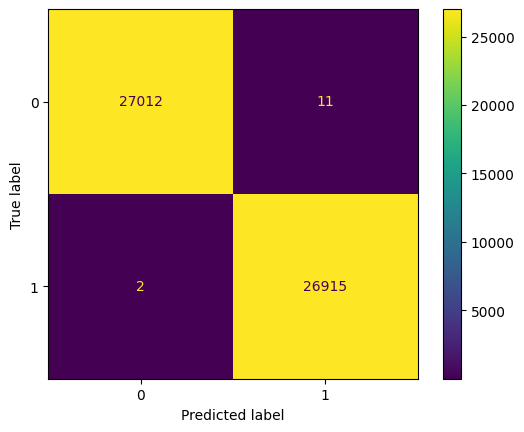

In [5]:
# Load Best Model
best_model = load_model("Backend/saved_model/phishing_detector.keras")

# Make Predictions
Y_pred_prob = best_model.predict(X_test_reshaped)
Y_pred = (Y_pred_prob > 0.5).astype(int)

# Evaluate Model Performance
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()